In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.rcParams['savefig.dpi'] = 100

In [2]:
from straightline_utils import *

/Users/ajordan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


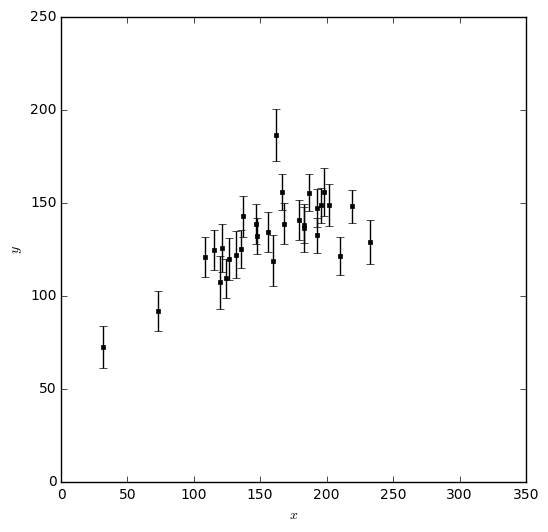

In [3]:
(x,y,sigmay) = generate_data()

plot_yerr(x, y, sigmay)

Weighted least-squares estimated b,m: 80.3006475818 0.328431054308


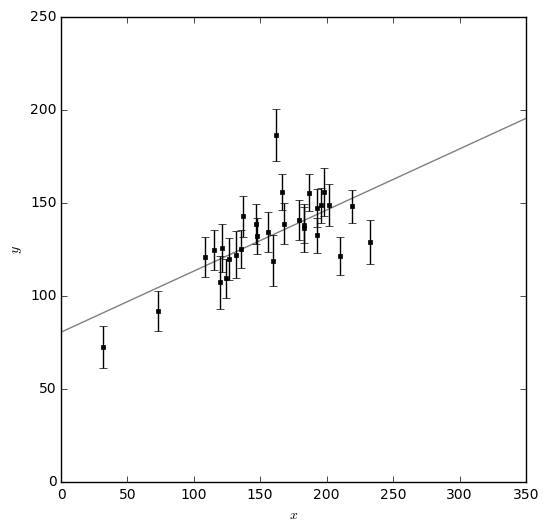

In [4]:
# solucion por weighted least squares
N = len(x)
A = np.zeros((N,2))
A[:,0] = 1. / sigmay
A[:,1] =  x / sigmay
yy = y / sigmay

theta,nil,nil,nil = np.linalg.lstsq(A,yy)

b_ls,m_ls = theta
print('Weighted least-squares estimated b,m:', b_ls,m_ls)

plot_yerr(x, y, sigmay)
plot_line(m_ls, b_ls);

In [5]:
# aca esta el likelihood para el modelo y = mx + b
def straight_line_log_likelihood(theta, x, y, sigmay):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y_t = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept

    Returns: scalar log likelihood
    '''
    m,b = theta
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / sigmay**2))

In [6]:
# y aqui un prior. theta es el vector de parámetros (m,b)
def straight_line_log_prior(theta, theta_limits):
    m, b = theta
    mlimits, blimits = theta_limits
    
    # Uniform in m:
    if (m < mlimits[0]) | (m > mlimits[1]):
        log_m_prior = -np.inf
    else:
        log_m_prior = np.log(1.0/(mlimits[1] - mlimits[0]))
    # Uniform in b:
    if (b < blimits[0]) | (b > blimits[1]):
        log_b_prior = -np.inf
    else:
        log_b_prior = np.log(1.0/(blimits[1] - blimits[0]))
        
    return log_m_prior + log_b_prior

# la posterior es simplemente \propto likelihood x prior
def straight_line_log_posterior(theta, x, y, sigmay, theta_limits):
    return (straight_line_log_likelihood(theta, x, y, sigmay) +
            straight_line_log_prior(theta, theta_limits))

Grid maximum posterior values (m,b) = 0.32 82.0


/Users/ajordan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


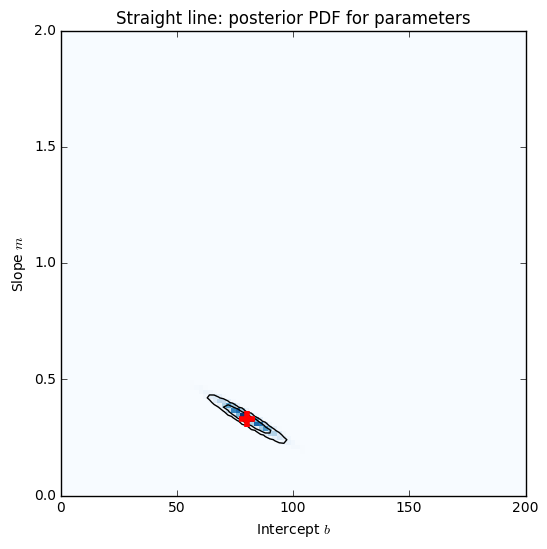

In [7]:
# Evaluamos log P(m,b | x,y,sigmay) en una grilla

# Priors uniformes, exigimos m,b>0
mlimits = [0.0, 2.0]
blimits = [0.0, 200.0]
theta_limits = (mlimits, blimits)

# Grilla
mgrid = np.linspace(mlimits[0], mlimits[1], 101)
bgrid = np.linspace(blimits[0], blimits[1], 101)
log_posterior = np.zeros((len(mgrid),len(bgrid)))

# evaluamos la posterior en la grilla
for im,m in enumerate(mgrid):
    for ib,b in enumerate(bgrid):
        theta = (m,b)
        log_posterior[im,ib] = straight_line_log_posterior(theta, x, y, sigmay, theta_limits)

        
# convertimos a una PDF, restando log_posterior_max() para tener cuidado con problemas numericos

posterior = np.exp(log_posterior - log_posterior.max())

plt.imshow(posterior, extent=[blimits[0],blimits[1],mlimits[0],mlimits[1]],cmap='Blues',
           interpolation='none', origin='lower', aspect=(blimits[1]-blimits[0])/(mlimits[1]-mlimits[0]),
           vmin=0, vmax=1)
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')

i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print('Grid maximum posterior values (m,b) =', mgrid[i], bgrid[j])

plt.title('Straight line: posterior PDF for parameters');
plt.plot(b_ls, m_ls, 'r+', ms=12, mew=4);
plot_mb_setup(*theta_limits);

In [8]:
# ahora, uds deben definir una funcion que use un metropolis-hastings para samplear la posterior
def metropolis(log_posterior, theta, theta_limits, stepsize, nsteps=10000):
    '''
    log_posterior: funcion de theta
    theta_limits:  el rango para los priors uniformes que usaremos
    stepsize:      escalar o vector de largo len(theta) que nos da la escala de los steps del MCMC
    nsteps:        cuantas samples quiero
    '''
    
    
    # el output debe ser: la cadena (arreglo de tamaño (nsteps,npar)), log de los valores de la PDF 
    # en cada punto de la cadena, y el acceptance rate (que fraccion de los steps son aceptados)
    return chain,log_probs,acceptance_rate

##Ahora corramos el MCMC

In [9]:
# Inicializamos m y b al centro del prior:
m = 0.5*(mlimits[0]+mlimits[1])
b = 0.5*(blimits[0]+blimits[1])
theta = np.array([m,b])

# tamaño de los steps, 2% y 5% del rango del prior
mstep = 0.02*(mlimits[1]-mlimits[0])
bstep = 0.05*(blimits[1]-blimits[0])
stepsize = np.array([mstep,bstep])        
    
# numero total de pasos
nsteps = 10000
   
print('Running Metropolis Sampler for', nsteps, 'steps...')

chain, log_probs, acceptance_rate = metropolis(
    straight_line_log_posterior, theta, theta_limits, stepsize, nsteps=nsteps
)

print('Acceptance fraction:', acceptance_rate)

Running Metropolis Sampler for 10000 steps...
Acceptance fraction: 0.1772


(0.0, 200.0)

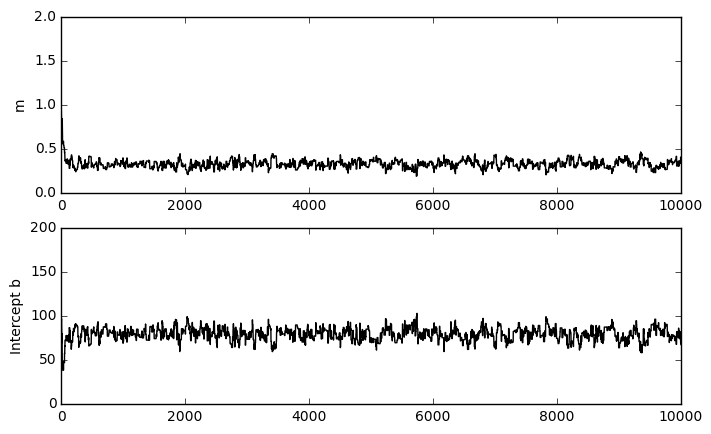

In [10]:
# Ahora sacamos los valores de m y b de la cadena y los ploteamos
mm = [m for m,b in chain]
bb = [b for m,b in chain]

# primero las 'trazas' para verificar convergencia
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlimits)
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'k-')
plt.ylabel('Intercept b')
plt.ylim(blimits)

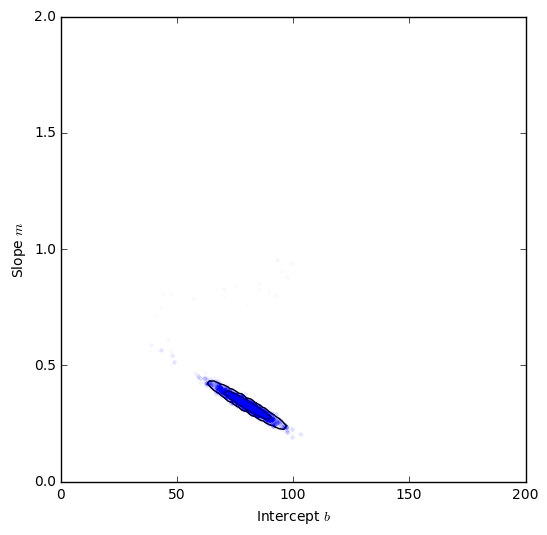

In [11]:
# ploteamos los contornos del calculo basado en la grilla
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')
plt.gca().set_aspect((blimits[1]-blimits[0])/(mlimits[1]-mlimits[0]))

# ahora los puntos de las cadenas
plt.plot(bb, mm, 'b.', alpha=0.01)
plot_mb_setup(mlimits,blimits)

##usemos corner, un paquete dedicado para plotear resultados de MCMC

In [13]:
!pip install --upgrade --no-deps corner

Requirement already up-to-date: corner in /Users/ajordan/anaconda/lib/python2.7/site-packages


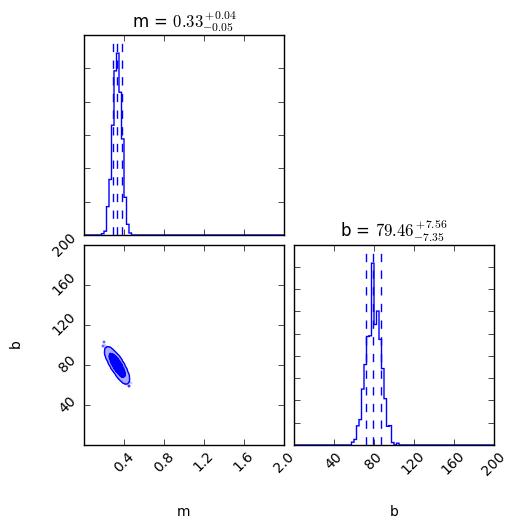

In [15]:
import corner
corner.corner(chain[5000:], labels=['m','b'], range=[mlimits,blimits],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='b', bins=80, smooth=1.0);

## chequeo visual del modelo

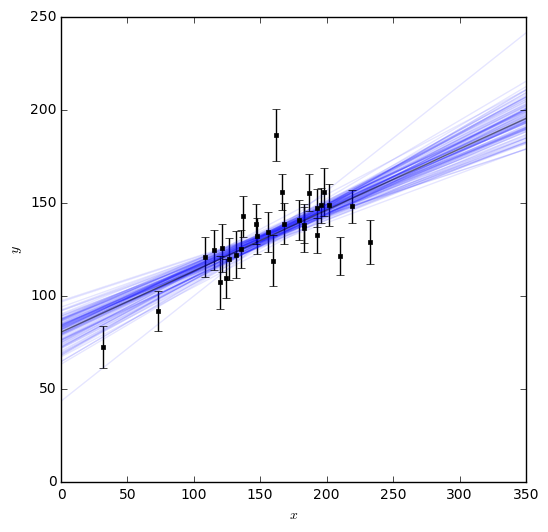

In [16]:
# Generate a straight line model for each parameter combination, and plot:
X = np.linspace(xlimits[0],xlimits[1],50)
for i in (np.random.rand(100)*len(chain)).astype(int):
    m,b = chain[i]
    plt.plot(X, b+X*m, 'b-', alpha=0.1)
plot_line(m_ls, b_ls)

# Overlay the data, for comparison:
plot_yerr(x, y, sigmay);